# Extreme Value Anlaysis using daily Precipitation data from Cal-Adapt API

In [1]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
from scipy.stats.distributions import genextreme
from scipy.stats.distributions import genpareto
from scipy.optimize import minimize, fmin

----
# Download data
----

Daily data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. Units for the observed data are mm and projected data are in kg/m2/s.

The code in the next cell contains a bunch of functions to:
    - fetch daily data given a slug and params
    - convert units to inches
    - return a new Pandas dataframe that contains all the data

In [2]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Request header
headers = {'ContentType': 'json'}

# Params
point = 'POINT(-121.4687 38.5938)'
params = {'g': point}

def mm_to_inches(val):
    return val * 0.0393701

def kgm2s_to_inches(val):
    return  (val * 86400) * 0.0393701

In [3]:
def process_daily_data(slug, params):
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        print('Processing:', slug)
        json = response.json()
        data = json['results'][0]

        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()

        # Get total number of values -> number of days
        length = len(values_arr)

        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')

        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index=pd.date_range(start_date, freq='1D', periods=length),
            columns=['value'],
        )

        # Convert units to Fahrenheit
        units = data['units']
        if units == 'mm':
            df.value = df.value.apply(lambda x: mm_to_inches(x))
        elif units == 'kg/m2/s':
            df.value = df.value.apply(lambda x: kgm2s_to_inches(x))
        else:
            pass
            
        # Add slug as a column
        df['series'] = slug.split('_')[2]
        
        # Add wateryear as a column
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['wateryear'] = np.where(df['month'] > 9, df['year'] + 1, df['year'])

    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

In [4]:
# Download observed daily timeseries
def get_observed():
    # Create slug
    slug = 'pr_day_livneh'
    df = process_daily_data(slug, params)
    return df

df = get_observed()
df

Processing: pr_day_livneh


,value,series,year,month,wateryear
1950-01-01,0.021879,livneh,1950,1,1950
1950-01-02,0.038984,livneh,1950,1,1950
1950-01-03,0.000000,livneh,1950,1,1950
1950-01-04,0.000000,livneh,1950,1,1950
1950-01-05,0.000000,livneh,1950,1,1950
1950-01-06,0.000000,livneh,1950,1,1950
1950-01-07,0.278853,livneh,1950,1,1950
1950-01-08,0.227935,livneh,1950,1,1950
1950-01-09,0.043757,livneh,1950,1,1950
1950-01-10,0.640446,livneh,1950,1,1950


----
# Select Threshold
----

Using a baseline period of wateryears 1961 - 1990, calculate the 90th, 95th and 99th percentiles of daily precipitation values within a water year from the observed data. Count number of days with values above threshold.

In [5]:
# CALCULATE THRESHOLDS

# Filter data by baseline time period
baselineDF = df.loc[(df['wateryear'] >= 1961) & (df['wateryear'] <= 1990) & (df['series'] == 'livneh')]

# Filter out zero precip values
baseline_nonzero = baselineDF.loc[(baselineDF['value'] > 0)]
threshold90 = baseline_nonzero['value'].quantile(0.90, interpolation='linear')
threshold95 = baseline_nonzero['value'].quantile(0.95, interpolation='linear')
threshold99 = baseline_nonzero['value'].quantile(0.99, interpolation='linear')

print('90th Percentile =', round(threshold90, 2), 'inch/day')
print('95th Percentile =', round(threshold95, 2), 'inch/day')
print('99th Percentile =', round(threshold99, 2), 'inch/day')

# Create Annual Maximum Series
baselineDF_max = baselineDF.groupby('wateryear').value.max()
threshold_minAMS = np.min(baselineDF_max)
print('Lowest value from Annual Maximum Series =', round(threshold_minAMS, 2), 'inch/day')

90th Percentile = 0.62 inch/day
95th Percentile = 0.87 inch/day
99th Percentile = 1.57 inch/day
Lowest value from Annual Maximum Series = 0.64 inch/day


----
# Extreme Value Analysis using Peak Over Threshold
----

Problem: Using Quantiles as threshold value in dry location has too few occurrences to meet requirements of statistical tests.

Solution: use minimum of annual maximum precipitation as threshold rather than percentiles (as default)

Question: Should we round this value?
286 exceedances above 0.6
255 exceedances above 0.64
257 exceedances above 0.635175897766

In [6]:
# Set threshold value to lowest value of Annual Maximum Series
threshold = threshold_minAMS
threshold = round(threshold_minAMS, 1)
print(threshold)

0.6


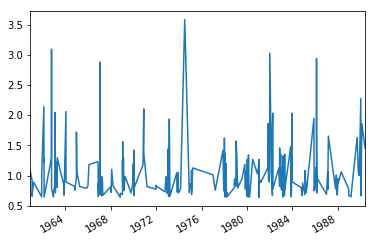

In [7]:
baselineDF.loc[baselineDF['value'] > threshold_minAMS].value.plot()

In [8]:
# Create an array of all non-zero daily values 
PDS = baselineDF['value'].values
print('Number of observations =', len(PDS))
print('Number of exceedances =', (PDS > threshold).sum())

Number of observations = 10957
Number of exceedances = 286


In [12]:
# Functions adapted from https://github.com/wcarthur/extremes

def returnLevels(intervals, mu, xi, sigma, rate, npyr):
    """
    Calculate return levels for specified intervals for a generalised pareto
    distribution with the given threshold, scale and shape parameters.

    :param intervals: :class:`numpy.ndarray` or float of recurrence intervals
              to evaluate return levels for.
    :param float mu: Threshold parameter (also called location).
    :param float xi: Shape parameter.
    :param float sigma: Scale parameter.
    :param float rate: Rate of exceedances (i.e. number of observations greater
                       than `mu`, divided by total number of observations).
    :param float npyr: Number of observations per year.

    :returns: return levels for the specified recurrence intervals.

    """

    rlevels = mu + (sigma / xi) * (np.power(intervals * npyr * rate, xi) - 1.)
    return rlevels

def empReturnPeriod(data, npyr):
    """
    Returns the empirically-based recurrence interval (in years) for a set
    of observations.

    It is assumed the data are daily observations. If the observations are not
    daily, there are two options: set the ``npyr`` variable, or backfill the
    ``data`` variable with zero values to match the assumed length of the
    record.

    The highest return period should be (approximately) len(``data``)/``npyr``.

    :param data: :class:`numpy.ndarray` containing the observed values (with
                 missing values removed).
    :param float npy: Number of observations per year (default=365.25)

    :returns: Recurrence intervals for the observed data.
    :rtype: :class:`numpy.ndarray`
    """
    nobs = len(data)
    # Empirical return periods:
    emprp = 1. / (1. - np.arange(1, nobs + 1, 1) / (nobs + 1)) / npyr
    return emprp

In [13]:
def extreme_value_analysis_gp(PDS, threshold, ri=[2, 5, 10, 20, 50, 100], units='inches', label='Baseline'):
    """
    Fit a Generalised Pareto model to a Partial Duration Series using the MLE estimation method,
    display the Density and Return Levels plots and calculate return levels for specified intervals.

    :param PDS: :class:`numpy.ndarray` non zero daily values for time period
    :param list ri: List of return intervals
    :param string units: Data units
    :param string label: Data label
    
    :returns: return levels for the specified recurrence intervals in a Pandas Dataframe

    """
        
    print('GP model fitted to Partial Duration Series Series using MLE estimation method')
    # Calculate distribution parameters
    params = genpareto.fit(PDS[PDS > threshold] - threshold, floc=0)
    shape, location, scale = params

    # Fit of GEV distribution based on MLE estimation (default in SciPy)
    gpa_fit = genpareto(*params)
    print('Estimated Parameters:')
    print('shape: {}, location: {}, scale: {}'.format(shape, location, scale))
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ## DENSITY PLOT
    # x axis values for plot
    x = np.linspace(gpa_fit.ppf(0.001), gpa_fit.ppf(0.999), 100)
    # plot
    ax1.plot(x, gpa_fit.pdf(x), label = 'Modeled', color = 'k')
    ax1.hist(PDS, density = True, color = 'yellow', alpha = 0.75, label = "Empirical")
    ax1.set_title('Density Plot')
    ax1.set_xlabel('Precipitation(mm)')
    ax1.set_ylabel('Probability')
    ax1.legend(loc='best', frameon=False) 
    
    ## RETURN VALUE PLOT
    # x axis values for plot
    rate = float(len(PDS[PDS > threshold])) / float(len(PDS))
    npyr = len(PDS) / 30
    rlevels = returnLevels(np.array(ri), threshold, shape, scale, rate, npyr)

    emprp = empReturnPeriod(PDS, npyr)
    sortedmax = np.sort(PDS)

    # plot
    ax2.set_title('Return Level Plot')
    ax2.set_xlabel('Return period')
    ax2.set_ylabel('Return level')
    ax2.grid(True)
    ax2.semilogx(ri, rlevels, label = 'Modeled RP', color = 'k')
    ax2.scatter(emprp[emprp > 1], sortedmax[emprp > 1], s=100, color='r', label="Empirical RP")
    ax2.legend(loc='best', frameon=False)
    
    # Get Return Levels (precipitation values) for Return Periods
    print('Return Levels:')
    for idx, val in enumerate(ri):
        print('{}-year Return Level = '.format(val), rlevels[idx], units)
    
    # Return pandas dataframe
    return pd.DataFrame({'RI': ri, 'RL': rlevels, 'Label': label})


GP model fitted to Partial Duration Series Series using MLE estimation method
Estimated Parameters:
shape: 0.13442109011338754, location: 0, scale: 0.3456827455233039
Return Levels:
2-year Return Level =  1.8504960464328923 inches
5-year Return Level =  2.351483878229515 inches
10-year Return Level =  2.773646809466719 inches
20-year Return Level =  3.2370349095640782 inches
50-year Return Level =  3.9197637793821785 inches
100-year Return Level =  4.495072804132461 inches


/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:1753: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2303: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


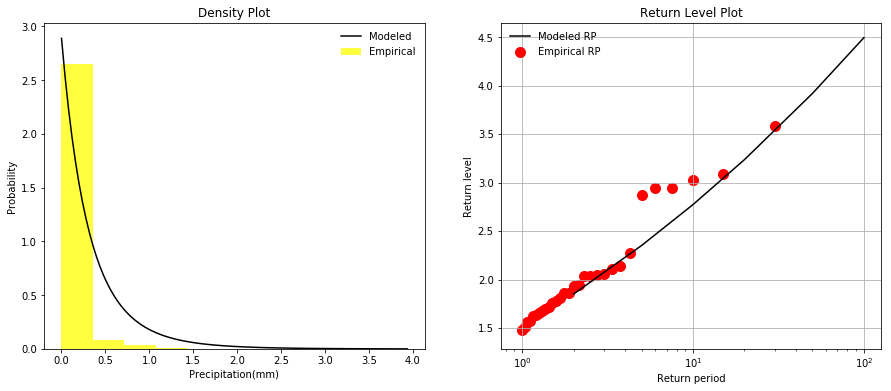

In [14]:
rl = extreme_value_analysis_gp(PDS, threshold, label='Livneh (1961-1990)')

---
# Digging into SciPy code
---

Code: https://github.com/scipy/scipy/blob/75ef94203a18fef9e78a46e66a6b6d23b946c1a7/scipy/stats/_distn_infrastructure.py

In [16]:
data = PDS[PDS > threshold] - threshold

The following cells show how the fit process works in SciPy - [link](https://stackoverflow.com/questions/49723946/retrieve-optimization-results-from-mle-by-scipy-stats-fit). Fit methods in R packages return some additional variables that are used later on for confidence interval calculations (I think). To get similar outputs from scipy fit method and to use different optimization methods, the following code examples can be used. Still some issues to be figured out for method='BFGS'.

In [27]:
# Finding MLE using fmin - this is default in scipy
args = genpareto._fitstart(data)
x0, func, restore, args = genpareto._reduce_func(args, {})
res = fmin(func, x0, args=(data,))
res

Optimization terminated successfully.
         Current function value: 19.447332
         Iterations: 107
         Function evaluations: 190


/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:1753: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2303: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


array([0.13929724, 0.00145223, 0.34266136])

In [28]:
# Finding MLE using the Nelder–Mead simplex algorithm
args = genpareto._fitstart(data)
x0, func, restore, args = genpareto._reduce_func(args, {})
res = minimize(func, x0, args=(data,), method='Nelder-Mead')
res

/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:1753: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2303: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


 final_simplex: (array([[0.13929724, 0.00145223, 0.34266136],
       [0.13921769, 0.00145221, 0.34262494],
       [0.13934281, 0.00145223, 0.34270811],
       [0.13925992, 0.0014522 , 0.34266109]]), array([19.44733238, 19.44733861, 19.44734659, 19.44734859]))
           fun: 19.447332383329353
       message: 'Optimization terminated successfully.'
          nfev: 190
           nit: 107
        status: 0
       success: True
             x: array([0.13929724, 0.00145223, 0.34266136])

In [30]:
# Finding MLE using the BFGS, this currently fails.
args = genpareto._fitstart(data)
x0, func, restore, args = genpareto._reduce_func(args, {})
res = minimize(func, x0, args=(data,), method='BFGS')
res

/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:1753: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2303: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


      fun: 169.5451046036612
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([  48.78179741, -438.44565392,  152.44565392])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 455
      nit: 0
     njev: 89
   status: 2
  success: False
        x: array([1., 0., 1.])

---
# Getting same results as R packages eva & extRemes
---

#### Estimated parameters from extRemes:

    scale     shape 
0.3456998 0.1343968 

#### Estimated parameters from eva:

Scale (Intercept)  0.34571   0.030791 11.2278 2.9797e-29

Shape (Intercept)  0.13436   0.067076  2.0031 4.5168e-02

#### To get similar results in SciPy hold location parameter fixed to 0 or threshold

In [35]:
params = genpareto.fit(PDS[PDS > threshold], floc=threshold)
#params = genpareto.fit(PDS[PDS > threshold] - threshold, floc=0)
params

/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:1753: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/mukhtyar/projects/caladapt-docs/env/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2303: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(0.13442109011338754, 0.6, 0.3456827455233039)